# Практическая задача

1. Найти небольшой датасет с текстами.
2. Подготовить тексты (лёгкая очистка и токенизация).
3. Векторизовать тексты с помощью CountVectorizer и TfidfVectorizer.
4. Обучить классификаторы (LogisticRegression, SVM, Random Forest).
5. Оценить модель через confusion matrix, precision, recall, F1.
6. Построить ROC/PR-кривые и сравнить результаты.
7. Использовать Pipeline + GridSearchCV для настройки параметров.

## Загрузка данных

In [42]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay

import matplotlib.pyplot as plt
import re
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [25]:
ds = load_dataset('imdb')

In [26]:
texts_train = ds["train"]["text"]
y_train = ds["train"]["label"]
texts_test = ds["test"]["text"]
y_test = ds["test"]["label"]

## Очистка текста и применение TF-IDF

In [29]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

In [33]:
cleaned_texts_train = [clean_text(t) for t in texts_train]
cleaned_texts_test = [clean_text(t) for t in texts_test]

In [36]:
tv = TfidfVectorizer(stop_words='english')
X_tfidf_train = tv.fit_transform(cleaned_texts_train)
X_tfidf_test = tv.transform(cleaned_texts_test)

## Обучение моделей

In [37]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
svm = LinearSVC(class_weight='balanced', max_iter=5000)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [38]:
lr.fit(X_cv_train,y_train)
svm.fit(X_cv_train, y_train)
rf.fit(X_cv_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Анализ результатов

In [51]:
for name, model, X_test in [
    ('LogReg', lr, X_tfidf_test),
    ('SVM', svm, X_tfidf_test),
    ('RandomForest', rf, X_cv_test)
]:
    y_pred = model.predict(X_test)
    print(name, classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

LogReg               precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Confusion matrix:
 [[10619  1881]
 [ 2208 10292]]
SVM               precision    recall  f1-score   support

           0       0.79      0.83      0.81     12500
           1       0.82      0.78      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000

Confusion matrix:
 [[10392  2108]
 [ 2795  9705]]
RandomForest               precision    recall  f1-score   support

           0       0.85      0.86      0.85     12500
           1       0.86      0.85      0.85     12500

    accuracy                           0.85     25000
   m

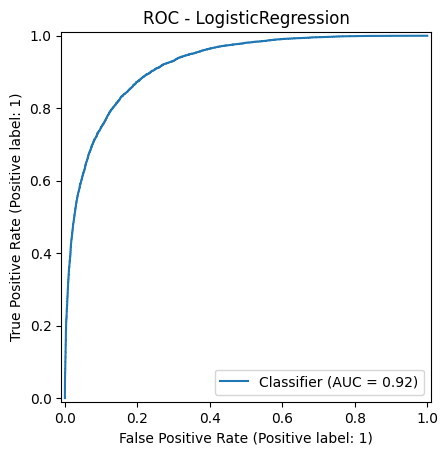

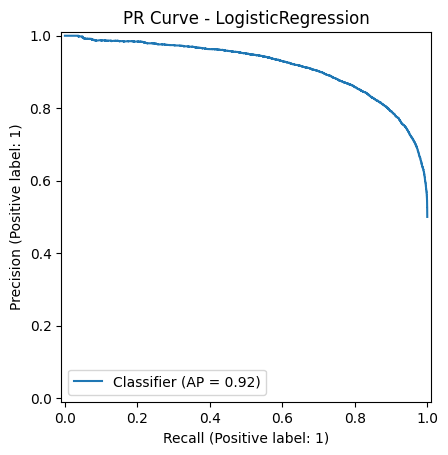

In [43]:
y_prob = lr.predict_proba(X_tfidf_test)[:,1]
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC - LogisticRegression")
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("PR Curve - LogisticRegression")
plt.show()

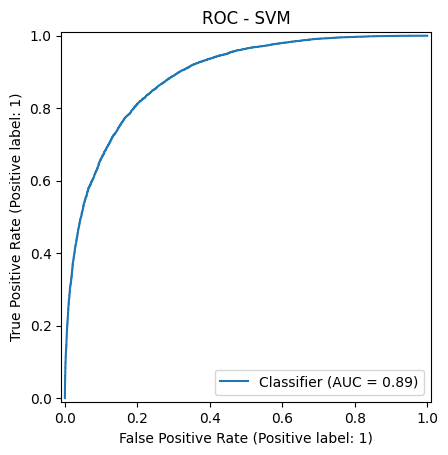

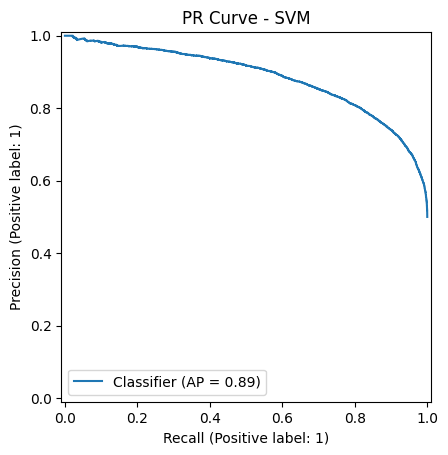

In [49]:
y_dec = svm.decision_function(X_tfidf_test)
RocCurveDisplay.from_predictions(y_test, y_dec)
plt.title("ROC - SVM")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_dec)
plt.title("PR Curve - SVM")
plt.show()

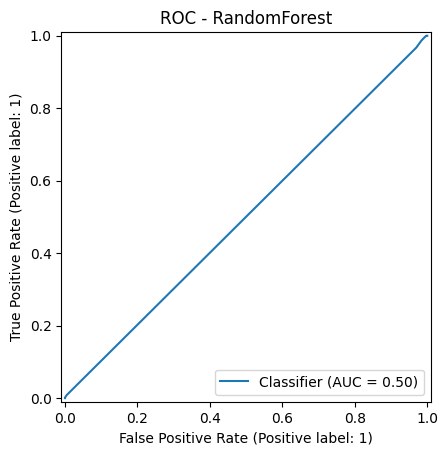

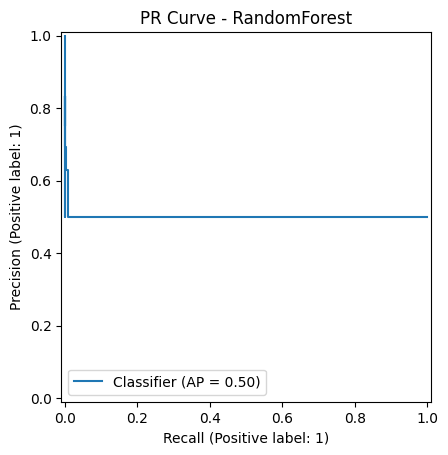

In [50]:
y_pred_prob = rf.predict_proba(X_tfidf_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC - RandomForest")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob)
plt.title("PR Curve - RandomForest")
plt.show()

SVM и LogisticRegression уверенно различают классы благодаря линейной структуре пространства TF‑IDF и способны давать хорошие ROC и PR результаты (AUC ≈ 0.89).

RandomForest с базовыми настройками оказался неэффективным на таком типе данных (AUC = 0.5).

Часто для TF‑IDF и NLP задач линейные модели оказываются лучшим выбором.

RandomForest требует аккуратной настройки и может уступить при высокой размерности признаков.

## Подберем параметры

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [53]:
pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [62]:
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_df': [0.75, 1.0],
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__C': [0.01, 0.1, 1.0, 10],
    'clf__l1_ratio': [0.2, 0.5, 0.8],   # используем только с elasticnet
    'clf__tol': [1e-4, 1e-3],
}

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv = StratifiedKFold(3), scoring='f1', n_jobs=-1)

texts_train_list = list(cleaned_texts_train)
y_train_list = list(y_train)
grid.fit(texts_train_list, y_train_list)
print(grid.best_params_, grid.best_score_)
best_model = grid.best_estimator_

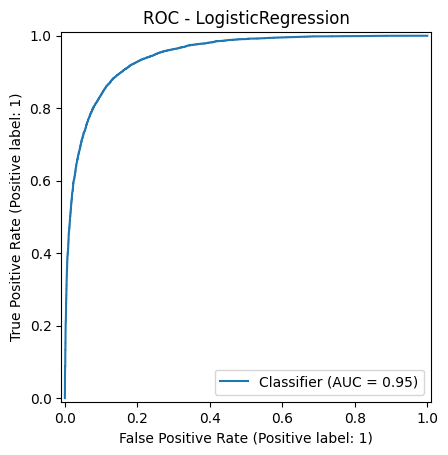

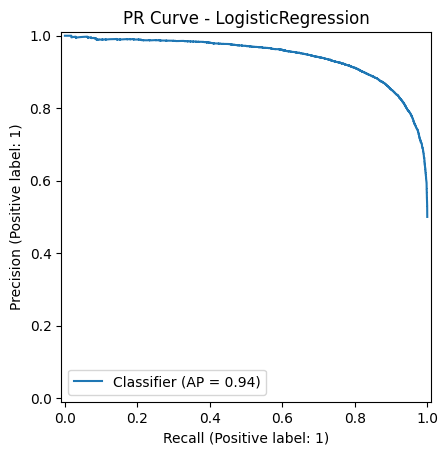

In [60]:
texts_test_list = list(cleaned_texts_test)

y_bext_prob = best_model.predict_proba(texts_test_list)[:,1]
RocCurveDisplay.from_predictions(y_test, y_bext_prob)
plt.title("ROC - LogisticRegression")
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_bext_prob)
plt.title("PR Curve - LogisticRegression")
plt.show()